##### Import

In [1]:
## python import

import yfinance as yf
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as datetime
from scipy.stats import norm

###### Yahoo Down load

In [2]:

StartDate=datetime.datetime(2008,1,1)
EndDate=datetime.datetime.today()


In [3]:
StartDate

datetime.datetime(2008, 1, 1, 0, 0)

In [ ]:
# yahoo datadown
VIX=yf.download('^vix',StartDate,EndDate)
SKEW=yf.download('^skew',StartDate,EndDate)
SPX=yf.download('^gspc',StartDate,EndDate)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/multitasking/__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/yfinance/multi.py", line 167, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/yfinance/multi.py", line 179, in _download_one
    return Ticker(ticker).history(period=period, interval=interval,
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/py

In [5]:
VIX.columns=['vix_high','vix_low','vix_open','vix_close','vix_volume','vix_adj_close']
SKEW.columns=['skew_high','skew_low','skew_open','skew_close','skew_volume','skew_adj_close']
SPX.columns=['spx_high','spx_low','spx_open','spx_close','spx_volume','spx_adj_close']

##### Save pd data to excel

In [6]:
cf=pd.concat([VIX,SKEW,SPX],axis=1)

In [7]:
cf.to_excel("cf.xlsx")

##### Load excel data

In [8]:
result=pd.read_excel("cf.xlsx")

In [9]:
Dates = result['Date']
results=result.iloc[:,1:]
results.index=Dates
resultss=results.fillna(method='ffill')
df=resultss

#####  Predict realized volatility with Intra information of high and low 

In [10]:
df['spx_hl']=np.power(np.log(df['spx_high'])-np.log(df['spx_low']),2)
df['spx_oc']=np.power((np.log(np.maximum(df['spx_open'],df['spx_close']))-np.log(np.minimum(df['spx_open'],df['spx_close']))),2)
df['spx_on']=np.power(df['spx_close'].pct_change(),2)
df['spx_vidl']=0.8*(df['spx_hl']-df['spx_oc'])+0.2*(df['spx_on'])
exp_weight=[0.00170074,0.00426233,0.00743368,0.01111781,0.01525666,0.0198101,0.0247481,0.03004702,0.0356876,0.04165371,0.04793159,0.05450928,0.06137628,0.06852326,0.07594184,0.08362446,0.09156423,0.09975485,0.10819051,0.11686595]
df['spx_vid']=df['spx_vidl'].rolling(len(exp_weight)).apply(lambda x:np.sqrt(np.sum(np.array(x)*np.array(exp_weight))*250),raw=True)

df['rv']=df['vix_close']/100-df['spx_vid']


In [11]:
df['spx_vid'].tail(20)

Date
2021-06-11    0.021193
2021-06-14         NaN
2021-06-15         NaN
2021-06-16         NaN
2021-06-17         NaN
2021-06-18         NaN
2021-06-21    0.031102
2021-06-22    0.034467
2021-06-23    0.034323
2021-06-24    0.037877
2021-06-25    0.038056
2021-06-28    0.033336
2021-06-29    0.032588
2021-06-30    0.032368
2021-07-01    0.033957
2021-07-02    0.039804
2021-07-06    0.020286
2021-07-07         NaN
2021-07-08         NaN
2021-07-09         NaN
Name: spx_vid, dtype: float64

##### Rolling data

In [12]:
df['spx_ret']=df['spx_close'].pct_change()
df['vix_ret']=df['vix_close'].diff()
df['spx_r_vol']=df['spx_ret'].rolling(window=20).std()*np.sqrt(252)
df['vix_20_mov']=df['vix_close'].rolling(window=22).mean()
df['skew_20_mov']=df['skew_close'].rolling(window=22).mean()
df['spx_hvol']=df['spx_ret'].rolling(10).std()*np.sqrt(252)
df['hrv']=df['vix_close'].shift(1)/100-df['spx_hvol']
df['spx_ewma_vol']=df['spx_ret'].ewm(10).std()*np.sqrt(252)


In [13]:
df[['spx_hvol','spx_vid','spx_ewma_vol','vix_close']].tail(5)

,spx_hvol,spx_vid,spx_ewma_vol,vix_close
Date,,,,
2021-07-02,0.068380,0.039804,0.087280,15.070000
2021-07-06,0.050144,0.020286,0.085532,16.440001
2021-07-07,0.048592,NaN,0.081869,16.200001
2021-07-08,0.072899,NaN,0.092269,19.000000
2021-07-09,0.085312,NaN,0.100241,16.180000


##### Vix and Skew Signal

In [14]:
df['vix_rank']=df['vix_20_mov'].rolling(window=500).apply(lambda x:( x.rank(ascending=True)[-1])/500,raw=False)
df['skew_rank']=df['skew_20_mov'].rolling(window=500).apply(lambda x:( x.rank(ascending=True)[-1])/500,raw=False)

#### Trend Signal

In [15]:
df['vix_long_mov']=df['vix_close'].rolling(window=100).mean()
df['vix_short_mov']=df['vix_close'].rolling(window=5).mean()
df['vix_trend']=np.where(df['vix_long_mov']>df['vix_short_mov'],1,-1)

#### HRV_Signal

In [16]:
df['hrv']=df['vix_close'].shift(1)/100-df['spx_hvol']
df['hrv_signal']=np.where(df['hrv']>0,1,0)

#### EWMA_Signal

<AxesSubplot:xlabel='Date'>

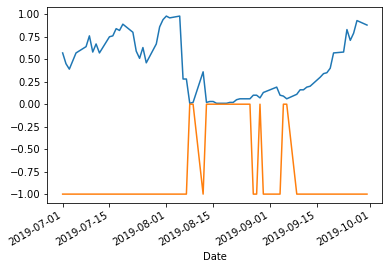

In [116]:
df['ewmav']=df['vix_close']/100-df['spx_ewma_vol']

df['ewmav_rank']=df['ewmav'].rolling(window=100).apply(lambda x:( x.rank(ascending=True)[-1])/100,raw=False)
df['ewmav_rank'].loc['2019-07-01': '2019-09-30'].plot()
df['ewmav_signal']=np.where(df['ewmav_rank'] >= 0.1,-1,0)
df['ewmav_signal'].loc['2019-07-01': '2019-09-30'].plot()

#### RV_Signal

In [117]:
df['rv_signal']=np.where(df['rv']>0,1,0)

<AxesSubplot:xlabel='Date'>

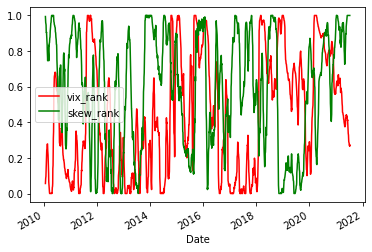

In [118]:
df.loc[:,['vix_rank','skew_rank']].plot(color='r''g', linestyle='-')

In [119]:
df[['vix_rank','skew_rank']].tail(5)

,vix_rank,skew_rank
Date,,
2021-07-02,0.274,1.0
2021-07-06,0.270,1.0
2021-07-07,0.268,1.0
2021-07-08,0.276,1.0
2021-07-09,0.270,1.0


#### Intra Signal

In [120]:
df['vix_2_mov']=df['vix_close'].rolling(window=2).mean()
scale_n=100
df['vol_rank']=df['vix_2_mov'].dropna().rolling(window=scale_n).apply(lambda x:( x.rank(ascending=True)[-1])/scale_n,raw=False)
df['intra_in_out']=np.where(df['vol_rank'] > 0.6,1,0)

#### Combine_VIX_Signal

In [121]:
df['com_vix_signal']=(1-df['vol_rank'])+df['ewmav_rank']
#df['com_vix_signal']=(1-df['vix_rank'])+df['skew_rank']
df['com_spx_in_out']=np.where(df['com_vix_signal']>=0.5,1,0)
df['com_vix_profit_taking']=np.where(df['com_vix_signal']>=1.5,1,0)
df['com_vix_profit_taking'].tail(100)
#df['com_vix_profit_taking'].plot()

Date
2021-02-17    0
2021-02-18    0
2021-02-19    0
2021-02-22    0
2021-02-23    0
             ..
2021-07-02    1
2021-07-06    1
2021-07-07    1
2021-07-08    1
2021-07-09    0
Name: com_vix_profit_taking, Length: 100, dtype: int32

#### Vol Expected

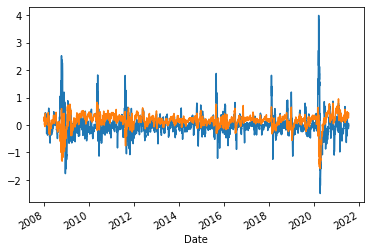

In [122]:
df['vix_diff']=df['vix_close'].diff(15)/15
df['vix_diff'].plot()
df['vix_carry']=df['ewmav']/22*100
df['vix_carry'].plot()


df['vix_diff_rank']=df['vix_diff'].dropna().rolling(window=250).apply(lambda x:( x.rank(ascending=True)[-1])/250,raw=False)
df['vix_carry_rank']=df['vix_carry'].dropna().rolling(window=250).apply(lambda x:( x.rank(ascending=True)[-1])/250,raw=False)

df['vix_ex']=df['vix_carry_rank']-df['vix_diff_rank']

##### Vix & Skew Signal

In [123]:

def vix_s(v,s):
    c=np.empty
    if v > 0.5 and s >0.5:
        c = 0 # 0.1
    elif v >0.5 and s <=0.75:
        c= -1.5  #9.5
    elif v<=0.5 and s > 0.5:
        c = -1
    elif v <=0.5 and s <= 0.5:
        c = -0.3
    else:
        c=0
    return c 
                        

In [124]:
def rt_s(r,t):
    c=np.empty
    if r >= 0 and t == 1:
        c = -0.4 # 0.1
    else:
        c= r
    return c 

In [125]:
df.tail()

,vix_high,vix_low,vix_open,vix_close,vix_volume,vix_adj_close,skew_high,skew_low,skew_open,skew_close,...,rt_signal,seokgoo_spx_signal,spx_intra_vol,seokgoo_spx_intra_barri,seokgoo_vix_signal,seokgoo_profit_taking,seokgoo_intra_in_out,spx_fut_ret,vix_fut_ret,wei
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,15.530000,15.540000,14.25,15.070000,15.070000,0,157.940002,157.940002,157.940002,157.940002,...,-1.0,BUY S&P500,-0.006624,-0.173695,Sell VIX,No Action,No Action,0.007500,-0.410000,-0.837405
2021-07-06,15.770000,17.940001,15.73,16.440001,16.440001,0,157.940002,157.940002,157.940002,157.940002,...,-1.0,BUY S&P500,0.000000,-0.156820,Sell VIX,Profit_taking,No Action,-0.002022,1.370001,-0.581221
2021-07-07,16.430000,17.639999,16.08,16.200001,16.200001,0,153.750000,153.750000,153.750000,153.750000,...,-1.0,BUY S&P500,-0.002494,-0.164730,Sell VIX,No Action,No Action,0.003359,-0.240000,-0.604366
2021-07-08,17.740000,21.290001,17.74,19.000000,19.000000,0,152.820007,152.820007,152.820007,152.820007,...,-1.0,BUY S&P500,-0.002270,-0.160022,Sell VIX,No Action,No Action,-0.008561,2.799999,-0.157774
2021-07-09,17.879999,18.129999,16.08,16.180000,16.180000,0,155.699997,155.699997,155.699997,155.699997,...,-1.0,BUY S&P500,-0.009662,-0.210510,Sell VIX,No Action,No Action,0.011278,-2.820000,-0.534651


In [126]:
df['vix_signal']=df.loc[:,['vix_rank','skew_rank']].dropna().apply(lambda x: vix_s(x[0],x[1]),axis=1)
df['rt_signal']=df.loc[:,['vix_signal','vix_trend']].dropna().apply(lambda x: rt_s(x[0],x[1]),axis=1)

In [127]:
#df['seokgoo_vix_signal']=df['rt_signal'].shift(1)
df['seokgoo_spx_signal']=np.where(df['com_spx_in_out'].shift(1)==1,'BUY S&P500','Neutral')
df['spx_intra_vol']=(df['spx_high']-df['spx_low'])/df['spx_close']
df['seokgoo_spx_intra_barri']=df['spx_intra_vol'].rolling(5).mean()*100*0.5

df['seokgoo_vix_signal']=np.where(df['ewmav_signal']==-1, 'Sell VIX','Neutral')
df['seokgoo_profit_taking']=np.where(df['com_vix_profit_taking'] ==1,'Profit_taking','No Action')
df['seokgoo_intra_in_out']=np.where(df['intra_in_out'] ==1, 'Enter','No Action')

seokgoo=pd.concat([df['seokgoo_spx_signal'],df['seokgoo_vix_signal'],df['seokgoo_profit_taking'],df['seokgoo_intra_in_out'],df['seokgoo_spx_intra_barri']],axis=1)
print(seokgoo.tail(2))

           seokgoo_spx_signal seokgoo_vix_signal seokgoo_profit_taking  \
Date                                                                     
2021-07-08         BUY S&P500           Sell VIX         Profit_taking   
2021-07-09         BUY S&P500           Sell VIX             No Action   

           seokgoo_intra_in_out  seokgoo_spx_intra_barri  
Date                                                      
2021-07-08            No Action                -0.160022  
2021-07-09            No Action                -0.210510  


#####  Return Simulation

In [128]:
df['spx_fut_ret']=df['spx_ret']
df['vix_fut_ret']=df['vix_ret']

<AxesSubplot:xlabel='Date'>

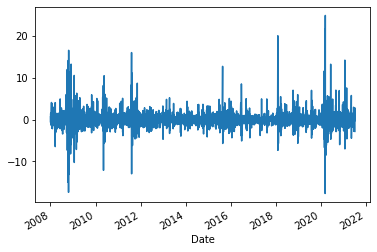

In [129]:
df['vix_fut_ret'].plot()

In [138]:
C=df['rt_signal'].shift(1)*df['spx_fut_ret']*-1
C1=df['rv_signal'].shift(2)*df['spx_fut_ret']*df['hrv_signal'].shift(2)*2
C2=df['com_spx_in_out'].shift(3)*df['spx_fut_ret']
C4=df['com_vix_profit_taking'].shift(2)*df['vix_fut_ret']
BM=df['spx_fut_ret']
#C1=(df['rv_signal'].shift(2)*df['skew_rank'].shift(2))*df['spx_fu_ret']*3#*df['ewmarv_signal'].shift(1)
#C1=df['hrv_signal'].shift(1)*df['spx_fu_ret']*5
CCC=(1+C).cumprod()
CCC1=(1+BM).cumprod()
CCC2=(1+C2).cumprod()
CD=C4.cumsum()

<AxesSubplot:xlabel='Date'>

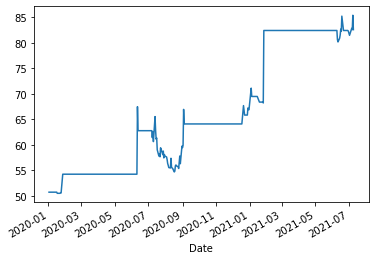

In [140]:
CD.loc['2020-01-01':].plot()

<AxesSubplot:xlabel='Date'>

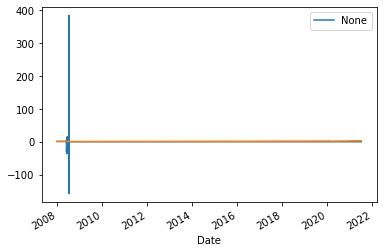

In [137]:
CCC2.loc['2007-01-01':].plot(legend=True)
CCC1.loc['2007-01-01':].plot()

##### mean Reverstion Strategy

In [108]:
def mean_reverting(da,nday):
    import numpy as np
    ww=[]
    for i in range(nday):
        ww.append(i+1)
    da=np.array(da)
    weight=np.dot(da,ww)*-1*4
    #weight=np.where(weight<0,0,weight)
    return weight

In [109]:
ww=[]
for i in range(5):
    ww.append(i+1) 
ww

[1, 2, 3, 4, 5]

In [110]:
q=np.array(ww)

In [111]:
x=df['spx_ret'].tail(5).T
mean_reverting(x,5)

-0.14271573912609892

In [112]:
df['wei']=df['spx_ret'].dropna().rolling(10).apply(lambda x: mean_reverting(x,10),raw=False)

In [113]:
df['wei'].tail(5)

Date
2021-07-02   -0.837405
2021-07-06   -0.581221
2021-07-07   -0.604366
2021-07-08   -0.157774
2021-07-09   -0.534651
Name: wei, dtype: float64

<AxesSubplot:xlabel='Date'>

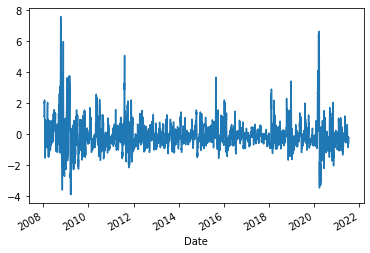

In [114]:
df['wei'].plot()

In [115]:
#sendtxt=seokgoo.columns.values.tolist()+seokgoo.tail(1).values.tolist()


In [76]:
txtcol=seokgoo.columns.values.tolist()
txtval=seokgoo.tail(1).values.tolist()

In [77]:
str(txtval[0][0])

'BUY S&P500'

In [78]:
import telepot

In [154]:
ma=txtcol[0]+':'+ str(txtval[0][0])+'\n'+txtcol[1]+':'+ str(txtval[0][1])+'\n'+txtcol[2]+':'+ str(txtval[0][2])+'\n'+txtcol[3]+':'+ str(txtval[0][3])+'\n'

In [155]:
ma

'seokgoo_spx_signal:BUY S&P500\nseokgoo_vix_signal:Sell VIX\nseokgoo_profit_taking:Profit_taking\nseokgoo_intra_in_out:No Action\n'

In [159]:
#bot=telepot.Bot(token=)
#'1869681798:AAHUK-pLER5Uah_xHYkD6TgUBgph8Aa2kkM'
#id1='508255215' #남석구
#id2='34316367' #이승민
#id3='1524661832' # 이상훈
#id4='1863846600' #주완석
#id5='1854200369'

In [160]:
li=[id1,id2,id3,id4,id5]

In [167]:
for i in li:
    bot.sendMessage(i,'저는 Stone9입니다. 오늘 시그널 보내 드립니다') 
    bot.sendMessage(i,'새롭게  Profit Taking Signal이 추가 되었습니다.') 
    bot.sendMessage(i,'만약 시그널이 나오면 위 험포지션 전략의 절반 청산 추천 그리고 현재 이시그널은 6/28일부터 작동되고 있습니다')
    bot.sendMessage(i,txtcol[0]+':'+ str(txtval[0][0])+'\n'+txtcol[1]+':'+ str(txtval[0][1])+'\n'+txtcol[2]+':'+ str(txtval[0][2])+'\n'+txtcol[3]+':'+ str(txtval[0][3]))
  